In [1]:
import pipic
from pipic import consts, types
import numpy as np
from numba import cfunc, carray
import matplotlib.pyplot as plt

In [2]:
# simulation variables 
temperature = 1e-6 * consts.electron_mass * consts.light_velocity**2
density = 1e18
debye_length = np.sqrt(temperature / (4 * np.pi * density * consts.electron_charge**2))
plasma_period = np.sqrt(np.pi * consts.electron_mass / (density * consts.electron_charge**2))
l = 128 * debye_length
xmin, xmax = -l / 2, l / 2
ymin, ymax = -1 , 1
zmin, zmax = -1,  1
field_amplitude = 0.01 * 4 * np.pi * (xmax - xmin) * consts.electron_charge * density
nz, ny, nx = 1, 1, 128
timestep = plasma_period / 64

dmin = - l/4
dmax = + l/4
field_amplitude

np.float64(-4105.632432413095)

In [8]:
# Define functions for initiating the simulation
@cfunc(types.add_particles_callback)
def density_profile(r, data_double, data_int):
    return density


@cfunc(types.field_loop_callback)
def initial_field(ind, r, E, B, data_double, data_int):
    if dmin < r[0] < dmax:
        E[0] = field_amplitude * np.sin(4*np.pi * r[0]/ (xmax-xmin))

In [9]:
# initialize simulation 
sim=pipic.init(solver='ec2', # using energy-conserving (ec) solver, other options include 'fourier_boris'
               xmin=xmin,xmax=xmax,
               ymin=ymin,ymax=ymax,
               zmin=zmin,zmax=zmax,
               nx=nx,ny=ny,nz=nz)

# add particles according to density_profile
sim.add_particles(name='particle_name',
                  number= nx*ny*nz*200, # total number of particles to add 
                  density=density_profile.address,
                  charge=consts.electron_charge,
                  mass=consts.electron_mass,
                  temperature=temperature,)

# add field according to initial_field
sim.field_loop(handler=initial_field.address) # setting initial field



In [10]:
# define functions and arrays for reading and saving field and particle phase space 

# For reading Ez field at y=0, x=0
field_dd = np.zeros((1, nx), dtype=np.double)  # array for saving Ez-field
@cfunc(types.field_loop_callback)
def field_callback(ind, r, E, B, data_double, data_int):
    # read Ez in the xz plane at y=0
    data = carray(data_double, field_dd.shape, dtype=np.double)
    if ind[1] == ny // 2 and ind[2] == nz // 2: 
        data[0,ind[0]] = E[0]

# For reading particle phase space
particle_dd = np.zeros((64, nx), dtype=np.double)  # array for saving particle (integrated) phase-space
pmin = -np.sqrt(consts.electron_mass * temperature)*5 # minimum momentum
pmax = np.sqrt(consts.electron_mass * temperature)*5 # maximum momentum
dp = (pmax - pmin) / particle_dd.shape[0] # momentum step
dx = (xmax - xmin) / particle_dd.shape[1] # position step
@cfunc(types.particle_loop_callback)
def particle_callback(r, p, w, id, data_double, data_int):
    # save particle momentum and position
    data = carray(data_double, particle_dd.shape, dtype=np.double)
    ip = int(particle_dd.shape[0] * (p[0] - pmin) / (pmax - pmin))
    ix = int(particle_dd.shape[1] * (r[0] - xmin) / (xmax - xmin))
    if ip >= 0 and ip < particle_dd.shape[0] and ix < particle_dd.shape[1] and ix >= 0:
        data[ip, ix] += w[0] / (dx * dp) / density # normalize by dz, dp and density

Text(0, 0.5, '$E_z$ (StatV/cm)')

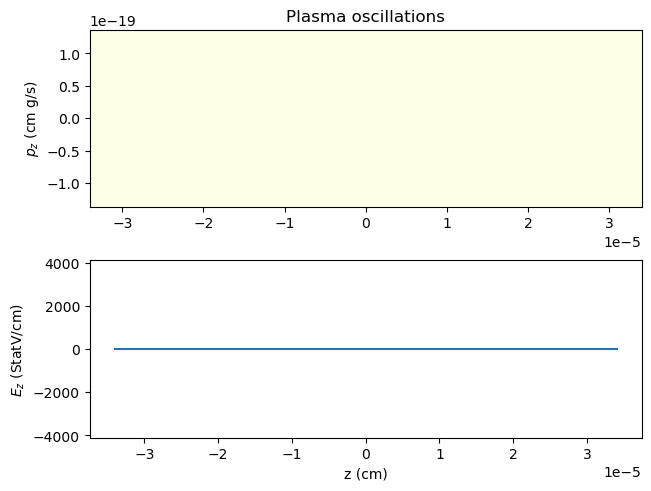

In [11]:
# initialize plot
fig, ax = plt.subplots(2, 1, constrained_layout=True)

z_axis = np.linspace(xmin, xmax, nx)
Ez_plot = ax[1].plot(z_axis,field_dd[0,:])[0]
ax[1].set_ylim(field_amplitude, -field_amplitude)
zpz_plot = ax[0].imshow(particle_dd / (3/pmax) / (zmax - zmin) / (ymax - ymin),  
             extent=[xmin, xmax,pmin, pmax], 
             aspect='auto', origin='lower', 
             cmap='YlOrBr',vmin=0, vmax=1,
             interpolation = 'none')


# set titles
ax[0].set_title('Plasma oscillations')
ax[1].set_xlabel('z (cm)')
ax[0].set_ylabel('$p_z$ (cm g/s)')
ax[1].set_ylabel('$E_z$ (StatV/cm)')

In [12]:
# ===============================SIMULATION======================================
save_gif = False # set to False to show with scrollbar

import numpy as np
from matplotlib import animation
from IPython.display import HTML, display, clear_output, Image


simulation_steps = int(8 * plasma_period / timestep)
frames = simulation_steps // 8 # number of frames to show in the animation
counter = 0
def animate(i):
    sim.advance(time_step=timestep, number_of_iterations=4,use_omp=True)
    sim.field_loop(handler=field_callback.address, 
                   data_double=pipic.addressof(field_dd),
                   use_omp=True)
    
    particle_dd.fill(0)
    sim.particle_loop(name='particle_name', 
                      handler=particle_callback.address, 
                      data_double=pipic.addressof(particle_dd))
    Ez_plot.set_ydata(field_dd)
    zpz_plot.set_data(particle_dd / (3/pmax) / (zmax - zmin) / (ymax - ymin))

    global counter
    clear_output()
    if counter <= frames:
        display(HTML('<pre> Progress: ' + "{:.2f}".format(100*counter/frames) + '%</pre>'), display_id = True)
    counter += 1
    return 

ani = animation.FuncAnimation(fig, animate, frames=frames, interval = 40)

if save_gif == False:
    html = HTML(ani.to_jshtml())
    display(html)
    plt.close()
else:
    writer = animation.PillowWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('output_basic_example.gif', writer=writer)